In [27]:
import os

assert os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] == "true"
assert os.environ["CUDA_DEVICE_ORDER"] == "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
# import tensorflow_hub as tf_hub
from pathlib import Path

In [7]:
BATCH_SIZE = 16
IMG_HEIGHT, IMG_WIDTH = (299, 299)
PREPROCESS_SEED = 123
CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_PATH = CHECKPOINT_DIR / "cp-{epoch:04d}.ckpt"


In [5]:
base_data_dir = Path("..", "..", "input", "arch-recognizer-dataset").absolute()
train_data_dir = base_data_dir / "train"
test_data_dir = base_data_dir / "test"

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="int",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names

train_ds.map(lambda i, _: tf.keras.applications.inception_resnet_v2.preprocess_input(i))
val_ds.map(lambda i, _: tf.keras.applications.inception_resnet_v2.preprocess_input(i))
test_ds.map(lambda i, _: tf.keras.applications.inception_resnet_v2.preprocess_input(i))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 9101 files belonging to 25 classes.
Using 7281 files for training.
Found 9101 files belonging to 25 classes.
Using 1820 files for validation.
Found 1012 files belonging to 25 classes.


In [32]:
def restore_weights(model):
    latest_cp = tf.train.latest_checkpoint(CHECKPOINT_DIR)
    if latest_cp:
        model.load_weights(latest_cp)
        _, restored_test_acc = model.evaluate(test_ds, verbose=2)
        print(f"Restored model test accuracy: {restored_test_acc}")
    return model

In [9]:
def create_resnet_app_model():
    _model = tf.keras.models.Sequential(
        [
            # Preprocessing
            tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
            # Augmentation
            tf.keras.layers.experimental.preprocessing.RandomFlip(
                "horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
            ),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
            
            # Convolution
            tf.keras.applications.InceptionResNetV2(
                include_top=True,
                weights=None,
                classes=len(class_names)
            )
        ]
    )
    _model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    return _model

In [11]:
model = restore_weights(create_resnet_app_model())

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(CHECKPOINT_PATH),
            verbose=1,
            save_weights_only=True,
            save_freq=BATCH_SIZE * 60,
        ),
        # tf.keras.callbacks.EarlyStopping(
        #     min_delta=0.0001, patience=10, restore_best_weights=True
        # ),
    ],
)

NameError: name 'restore_weights' is not defined

In [35]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

114/114 [==============================] - 21s 186ms/step - loss: 2.1123 - accuracy: 0.6462
Test Loss: 2.1123178005218506
Test Accuracy: 0.6461538672447205


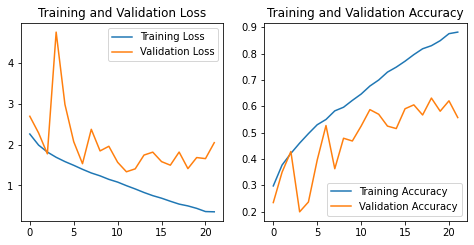

In [39]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
val_loss_range = range(len(loss))

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [10]:
import random

test_files = [
    os.path.join(path, filename)
    for path, _, files in os.walk(test_data_dir)
    for filename in files
    if filename.lower().endswith(".jpg")
]
img_path = Path(random.choice(test_files))

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

pred_y = class_names[np.argmax(score)]
true_y = img_path.parent.stem

plt.figure(figsize=(10, 10))
plt.title(
    f"pred: {pred_y}"
    f"\ntrue: {true_y}"
    f"\nconf: {100 * np.max(score):.2f}%",
    backgroundcolor="green" if pred_y == true_y else "red",
    horizontalalignment='right'
)
plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
plt.axis("off")

NameError: name 'model' is not defined